- Add weight decay
- Gaussian filter on initial input
- Black input and green output?
- Upsample all colour channels
- Reflection padding
- Average pooling for VGG instead of max pooling
- Custom loss function (mean absolute error)

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torch.utils.serialization import load_lua
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models, datasets

import numpy as np

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import time
import copy
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rc('figure', figsize=(12, 5))

use_cuda = torch.cuda.is_available()
use_cuda

True

In [2]:
mean_vec = torch.FloatTensor([ 0.485, 0.456, 0.406 ]).view(3,1,1)
std_vec = torch.FloatTensor([ 0.229, 0.224, 0.225 ]).view(3,1,1)

tensor_to_image = transforms.Compose([
    transforms.Lambda(lambda x: x * std_vec + mean_vec),
    transforms.ToPILImage()
])

def normalise(x):
    return (x - mean_vec) / std_vec

def denormalise(x):
    return x * std_vec + mean_vec

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

# create low resolution square images
def input_transform(crop_size, upscale_factor):
    return transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Scale(crop_size // upscale_factor),
        transforms.ToTensor(),
        transforms.Normalize(mean_vec, std_vec)
    ])

# maintain high resolution square images
def target_transform(crop_size):
    return transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean_vec, std_vec)
    ])

In [3]:
# load each image as a duplicate pair
class DoubleImageDataset(Dataset):
    
    def __init__(self, img_dir, input_transform, target_transform):
        super(DoubleImageDataset, self).__init__()
        
        self.image_fnames = [os.path.join(img_dir, f) for f in os.listdir(img_dir)]
        self.input_transform = input_transform
        self.target_transform = target_transform
    
    def __getitem__(self, index):
        img = Image.open(self.image_fnames[index]).convert('RGB')
        low_res = self.input_transform(img)
        high_res = self.target_transform(img)
        return low_res, high_res
    
    def __len__(self):
        return len(self.image_fnames)

In [4]:
train_dir = '/home/samir/Downloads/ILSVRC2012_img_train/train'
test_dir = '/home/samir/Downloads/ILSVRC2012_img_train/valid'

upscale_factor = 2
crop_size = calculate_valid_crop_size(256, upscale_factor)

train_dataset = DoubleImageDataset(
    train_dir,
    input_transform=input_transform(crop_size, upscale_factor),
    target_transform=target_transform(crop_size))

test_dataset = DoubleImageDataset(
    test_dir,
    input_transform=input_transform(crop_size, upscale_factor),
    target_transform=target_transform(crop_size))

data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=7,
    pin_memory=True)

# preview some images
low_res, high_res = next(iter(data_loader))

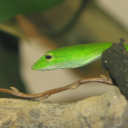

In [5]:
idx = 0
tensor_to_image(low_res[idx])

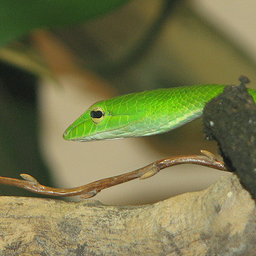

In [6]:
tensor_to_image(high_res[idx])

In [7]:
class ResidualBlock(nn.Module):
    
    def __init__(self, n_in, n_out):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(n_in, n_out, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(n_out)
        self.conv2 = nn.Conv2d(n_out, n_out, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(n_out)
        self.relu = nn.ReLU(inplace=True) # inplace??
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        # out = self.relu(out) # with or without relu??
        return out


class UpsampleBlock(nn.Module):
    
    def __init__(self, upscale_factor):
        super(UpsampleBlock, self).__init__()
        
        self.upsample = nn.Upsample(scale_factor=upscale_factor, mode='bilinear')
        self.conv = nn.Conv2d(64, 64, 3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)


class UpsamplingNetwork(nn.Module):
    
    def __init__(self, upscale_factor):
        super(UpsamplingNetwork, self).__init__()
        
        self.receptor = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding=4),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)) # inplace??
        
        self.resblock1 = ResidualBlock(64, 64)
        self.resblock2 = ResidualBlock(64, 64)
        self.resblock3 = ResidualBlock(64, 64)
        self.resblock4 = ResidualBlock(64, 64)
        
        self.upsampler1 = UpsampleBlock(upscale_factor)
        #self.upsampler2 = UpsampleBlock(upscale_factor) # another upsampler ??
        
        self.reducer = nn.Sequential(
            nn.Conv2d(64, 3, 9, padding=4))
        
    def forward(self, x):
        x = self.receptor(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.upsampler1(x)
        #x = self.upsampler2(x)
        x = self.reducer(x)
        return x

In [8]:
upsampling_net = UpsamplingNetwork(upscale_factor).cuda()

In [9]:
 # need to do AVG pooling ??
pretrained_model = models.vgg16(pretrained=True).features.cuda()
pretrained_model

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU (inplace)
  (19): Conv2d(512,

In [10]:
class PerceptualLossNetwork(nn.Module):
    
    def __init__(self, pretrained_model, extraction_layers, weights):
        super(PerceptualLossNetwork, self).__init__()
        
        for param in pretrained_model.parameters():
            param.requires_grad = False
        
        children = list(pretrained_model.children())
        
        modules = []
        i = 0
        for j, w in zip(extraction_layers, weights):
            modules.append((nn.Sequential(*children[i:j+1]), w))
            i = j+1
        self.modules = modules
        
        self.loss_fn = nn.MSELoss() # different loss function??
    
    
    def forward(self, x, target):
        
        total_loss = 0.0
        for module, weight in self.modules:
            x = module(x)
            target = module(target)
            total_loss += self.loss_fn(x, target) * weight
        return total_loss

In [11]:
percept_net = PerceptualLossNetwork(
    pretrained_model,
    [3, 8, 13], # different layers??
    [0.1, 0.8, 0.1]).cuda()

In [12]:
optimiser = optim.Adam(upsampling_net.parameters(), lr=1e-3) # decay??
loss_fn = nn.L1Loss()

In [13]:
num_epochs = 1
dummy_zero_targets = Variable(torch.zeros(1)).cuda()

print('Training ...')
start_time = time.time()

for epoch in range(num_epochs):
    print('Epoch {:3d}/{:3d}'.format(epoch, num_epochs))

    for i, (input_img, target_img) in enumerate(data_loader, 1):
        
        # load batch
        input_img = Variable(input_img).cuda(async=True)
        target_img = Variable(target_img).cuda(async=True)
        
        optimiser.zero_grad()
        
        # upsample
        predicted_img = upsampling_net(input_img)
        
        # compute perceptual loss
        percept_loss = percept_net(predicted_img, target_img)
        
        # calculate loss
        loss = loss_fn(percept_loss, dummy_zero_targets)
        loss.backward()
        
        optimiser.step()
        
        # if (i % 100 == 0):
        print('Batch #: {:3d} Loss: {:3f}'.format(i, loss.data[0]))

Training ...
Epoch   0/  1
Batch #:   1 Loss: 6.327007
Batch #:   2 Loss: 4.977562
Batch #:   3 Loss: 6.633346
Batch #:   4 Loss: 4.771792
Batch #:   5 Loss: 4.769319
Batch #:   6 Loss: 4.122464
Batch #:   7 Loss: 6.955916
Batch #:   8 Loss: 5.541607
Batch #:   9 Loss: 6.393931
Batch #:  10 Loss: 5.512401
Batch #:  11 Loss: 5.469779
Batch #:  12 Loss: 3.786810
Batch #:  13 Loss: 3.795086
Batch #:  14 Loss: 4.410380
Batch #:  15 Loss: 7.070016
Batch #:  16 Loss: 4.876771
Batch #:  17 Loss: 5.828636
Batch #:  18 Loss: 4.105208
Batch #:  19 Loss: 5.711858
Batch #:  20 Loss: 4.815291
Batch #:  21 Loss: 6.396812
Batch #:  22 Loss: 5.365613
Batch #:  23 Loss: 3.602515
Batch #:  24 Loss: 4.171595
Batch #:  25 Loss: 4.485384
Batch #:  26 Loss: 4.122534
Batch #:  27 Loss: 3.266950
Batch #:  28 Loss: 3.253770
Batch #:  29 Loss: 4.753036
Batch #:  30 Loss: 3.137299
Batch #:  31 Loss: 4.177526
Batch #:  32 Loss: 5.077761
Batch #:  33 Loss: 3.224799
Batch #:  34 Loss: 4.421322
Batch #:  35 Loss: 5.

Batch #: 293 Loss: 2.422641
Batch #: 294 Loss: 4.187741
Batch #: 295 Loss: 2.895544
Batch #: 296 Loss: 2.859822
Batch #: 297 Loss: 3.161817
Batch #: 298 Loss: 3.147853
Batch #: 299 Loss: 2.918585
Batch #: 300 Loss: 2.715499
Batch #: 301 Loss: 3.092650
Batch #: 302 Loss: 2.034944
Batch #: 303 Loss: 3.870817
Batch #: 304 Loss: 2.154900
Batch #: 305 Loss: 4.054487
Batch #: 306 Loss: 3.761711
Batch #: 307 Loss: 3.462270
Batch #: 308 Loss: 3.797319
Batch #: 309 Loss: 1.793748
Batch #: 310 Loss: 2.406722
Batch #: 311 Loss: 3.551285
Batch #: 312 Loss: 1.944022
Batch #: 313 Loss: 2.845045
Batch #: 314 Loss: 2.725113
Batch #: 315 Loss: 2.876445
Batch #: 316 Loss: 1.733313
Batch #: 317 Loss: 2.926371
Batch #: 318 Loss: 2.205846
Batch #: 319 Loss: 2.501821
Batch #: 320 Loss: 2.665525
Batch #: 321 Loss: 2.223489
Batch #: 322 Loss: 2.780037
Batch #: 323 Loss: 2.469970
Batch #: 324 Loss: 2.396531
Batch #: 325 Loss: 2.085560
Batch #: 326 Loss: 2.242454
Batch #: 327 Loss: 3.349497
Batch #: 328 Loss: 2

Batch #: 587 Loss: 2.402450
Batch #: 588 Loss: 3.303461
Batch #: 589 Loss: 2.499746
Batch #: 590 Loss: 2.537233
Batch #: 591 Loss: 1.275090
Batch #: 592 Loss: 2.138477
Batch #: 593 Loss: 2.561842
Batch #: 594 Loss: 2.736545
Batch #: 595 Loss: 1.566280
Batch #: 596 Loss: 2.932539
Batch #: 597 Loss: 2.761144
Batch #: 598 Loss: 3.269037
Batch #: 599 Loss: 2.538251
Batch #: 600 Loss: 2.559371
Batch #: 601 Loss: 3.078498
Batch #: 602 Loss: 2.480495
Batch #: 603 Loss: 3.085780
Batch #: 604 Loss: 2.712486
Batch #: 605 Loss: 3.153780
Batch #: 606 Loss: 2.352064
Batch #: 607 Loss: 3.363395
Batch #: 608 Loss: 2.499700
Batch #: 609 Loss: 2.143972
Batch #: 610 Loss: 3.865388
Batch #: 611 Loss: 2.457827
Batch #: 612 Loss: 2.534540
Batch #: 613 Loss: 2.471066
Batch #: 614 Loss: 2.687769
Batch #: 615 Loss: 2.807995
Batch #: 616 Loss: 3.562326
Batch #: 617 Loss: 2.104106
Batch #: 618 Loss: 2.320715
Batch #: 619 Loss: 3.947930
Batch #: 620 Loss: 2.131554
Batch #: 621 Loss: 2.185344
Batch #: 622 Loss: 3

Batch #: 881 Loss: 2.290150
Batch #: 882 Loss: 1.745604
Batch #: 883 Loss: 3.238079
Batch #: 884 Loss: 2.281151
Batch #: 885 Loss: 2.292021
Batch #: 886 Loss: 2.246628
Batch #: 887 Loss: 2.039214
Batch #: 888 Loss: 1.674034
Batch #: 889 Loss: 2.129946
Batch #: 890 Loss: 1.824356
Batch #: 891 Loss: 2.013807
Batch #: 892 Loss: 2.836556
Batch #: 893 Loss: 3.573058
Batch #: 894 Loss: 2.351623
Batch #: 895 Loss: 3.431980
Batch #: 896 Loss: 1.964299
Batch #: 897 Loss: 2.411161
Batch #: 898 Loss: 1.871056
Batch #: 899 Loss: 1.946954
Batch #: 900 Loss: 2.233858
Batch #: 901 Loss: 2.373867
Batch #: 902 Loss: 1.809538
Batch #: 903 Loss: 1.850380
Batch #: 904 Loss: 1.744546
Batch #: 905 Loss: 2.568352
Batch #: 906 Loss: 1.655452
Batch #: 907 Loss: 2.864233
Batch #: 908 Loss: 2.372378
Batch #: 909 Loss: 2.849180
Batch #: 910 Loss: 1.999812
Batch #: 911 Loss: 1.756040
Batch #: 912 Loss: 3.322022
Batch #: 913 Loss: 2.064972
Batch #: 914 Loss: 2.588283
Batch #: 915 Loss: 2.673658
Batch #: 916 Loss: 1

Batch #: 1169 Loss: 2.575965
Batch #: 1170 Loss: 1.881223
Batch #: 1171 Loss: 2.483655
Batch #: 1172 Loss: 2.529916
Batch #: 1173 Loss: 3.044371
Batch #: 1174 Loss: 2.528694
Batch #: 1175 Loss: 2.085190
Batch #: 1176 Loss: 2.497695
Batch #: 1177 Loss: 2.597120
Batch #: 1178 Loss: 2.825852
Batch #: 1179 Loss: 2.232584
Batch #: 1180 Loss: 2.035263
Batch #: 1181 Loss: 2.164135
Batch #: 1182 Loss: 2.236921
Batch #: 1183 Loss: 2.085688
Batch #: 1184 Loss: 2.278572
Batch #: 1185 Loss: 2.769585
Batch #: 1186 Loss: 2.719089
Batch #: 1187 Loss: 1.932825
Batch #: 1188 Loss: 3.118382
Batch #: 1189 Loss: 2.282143
Batch #: 1190 Loss: 1.538354
Batch #: 1191 Loss: 2.010103
Batch #: 1192 Loss: 2.634827
Batch #: 1193 Loss: 2.629110
Batch #: 1194 Loss: 2.026174
Batch #: 1195 Loss: 1.399056
Batch #: 1196 Loss: 2.013598
Batch #: 1197 Loss: 1.788912
Batch #: 1198 Loss: 1.855158
Batch #: 1199 Loss: 2.138188
Batch #: 1200 Loss: 2.567426
Batch #: 1201 Loss: 3.140509
Batch #: 1202 Loss: 2.390455
Batch #: 1203 

Batch #: 1453 Loss: 1.658784
Batch #: 1454 Loss: 2.052689
Batch #: 1455 Loss: 2.229290
Batch #: 1456 Loss: 2.115740
Batch #: 1457 Loss: 1.637372
Batch #: 1458 Loss: 2.296914
Batch #: 1459 Loss: 6.264365
Batch #: 1460 Loss: 1.837321
Batch #: 1461 Loss: 2.083782
Batch #: 1462 Loss: 1.531932
Batch #: 1463 Loss: 2.323364
Batch #: 1464 Loss: 1.388112
Batch #: 1465 Loss: 1.888050
Batch #: 1466 Loss: 2.863790
Batch #: 1467 Loss: 2.527600
Batch #: 1468 Loss: 1.847174
Batch #: 1469 Loss: 1.449079
Batch #: 1470 Loss: 2.342540
Batch #: 1471 Loss: 1.712355
Batch #: 1472 Loss: 1.464062
Batch #: 1473 Loss: 1.433331
Batch #: 1474 Loss: 1.439323
Batch #: 1475 Loss: 1.620206
Batch #: 1476 Loss: 2.525126
Batch #: 1477 Loss: 1.982397
Batch #: 1478 Loss: 3.103292
Batch #: 1479 Loss: 2.766937
Batch #: 1480 Loss: 2.046577
Batch #: 1481 Loss: 2.200399
Batch #: 1482 Loss: 1.986202
Batch #: 1483 Loss: 2.532955
Batch #: 1484 Loss: 1.977123
Batch #: 1485 Loss: 1.791997
Batch #: 1486 Loss: 2.526471
Batch #: 1487 

Batch #: 1737 Loss: 2.762083
Batch #: 1738 Loss: 2.321896
Batch #: 1739 Loss: 2.102928
Batch #: 1740 Loss: 1.759404
Batch #: 1741 Loss: 2.580478
Batch #: 1742 Loss: 2.398962
Batch #: 1743 Loss: 1.700950
Batch #: 1744 Loss: 2.020911
Batch #: 1745 Loss: 2.624529
Batch #: 1746 Loss: 2.186165
Batch #: 1747 Loss: 2.036165
Batch #: 1748 Loss: 2.547904
Batch #: 1749 Loss: 1.430651
Batch #: 1750 Loss: 1.937037
Batch #: 1751 Loss: 1.470159
Batch #: 1752 Loss: 1.930679
Batch #: 1753 Loss: 2.095562
Batch #: 1754 Loss: 2.762043
Batch #: 1755 Loss: 2.556739
Batch #: 1756 Loss: 1.647058
Batch #: 1757 Loss: 2.706651
Batch #: 1758 Loss: 1.638842
Batch #: 1759 Loss: 2.728445
Batch #: 1760 Loss: 1.839463
Batch #: 1761 Loss: 1.823462
Batch #: 1762 Loss: 2.420930
Batch #: 1763 Loss: 2.026281
Batch #: 1764 Loss: 3.482937
Batch #: 1765 Loss: 2.261206
Batch #: 1766 Loss: 2.280965
Batch #: 1767 Loss: 2.017301
Batch #: 1768 Loss: 3.507653
Batch #: 1769 Loss: 3.062789
Batch #: 1770 Loss: 1.647727
Batch #: 1771 

Process Process-12:
Process Process-13:
Process Process-14:
Process Process-9:
Process Process-11:
Traceback (most recent call last):
Process Process-8:
Traceback (most recent call last):
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process Process-10:
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.p

KeyboardInterrupt: 

## Test model

In [58]:
low_res, high_res = next(iter(data_loader))

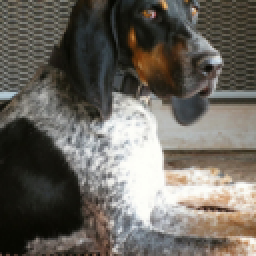

In [59]:
idx = 1
transforms.ToPILImage()(denormalise(low_res[idx])).resize((256,256))

-2.1542556285858154 2.6637966632843018


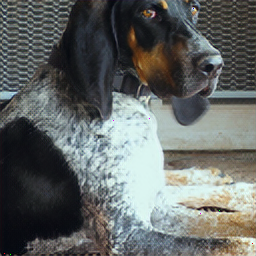

In [60]:
y = upsampling_net(Variable(low_res).cuda())
y = (y.cpu().data[idx])
print(y.min(), y.max())
tensor_to_image(y)

-2.1179039478302 2.640000104904175


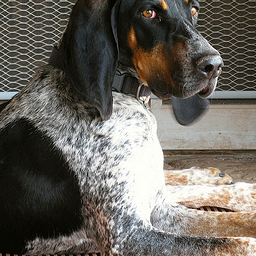

In [61]:
print(high_res[idx].min(), high_res[idx].max())
tensor_to_image(high_res[idx])

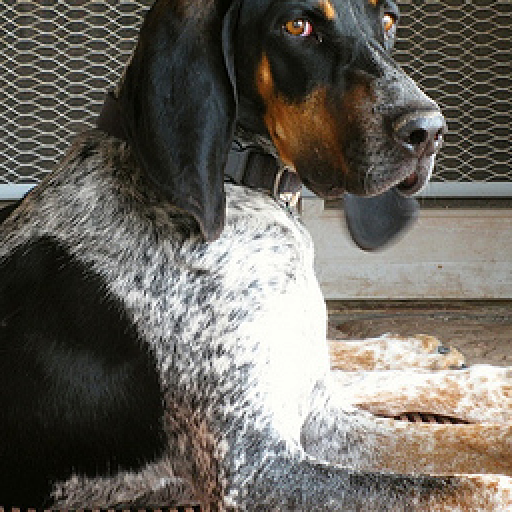

In [62]:
transforms.ToPILImage()(denormalise(high_res[idx])).resize((512,512))

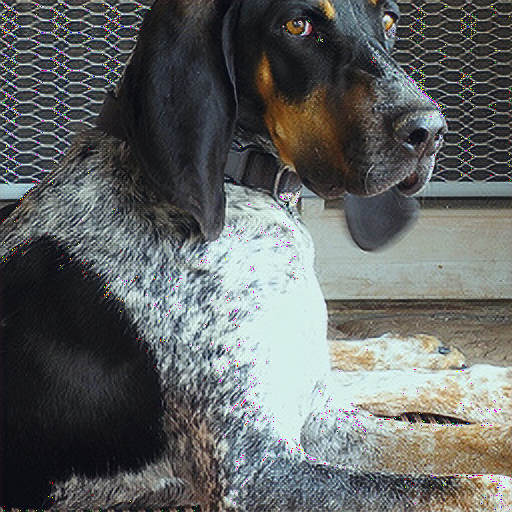

In [63]:
y = upsampling_net(Variable(high_res).cuda())
y = (y.cpu().data[idx])
tensor_to_image(y)